# Bike Sharing Assignment
A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues. They have contracted a consulting company to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:

- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands

You are required to model the demand for shared bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market. 

In [1]:
## necessary library import

## generic
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### modeling specfic
import statsmodels.api as sm
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


## 1. Data loading and Understanding

### Target variable is 'cnt'

In [2]:
df = pd.read_csv('day.csv')

In [3]:
df.head(2)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801


In [4]:
## instant is an index column hence dropping it
df.drop(['instant'],axis = 1,inplace =True)

In [5]:
df.head(2)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801


#### To check weekday column meaning 
- using dteday column date to find out significance of weekday number

<b>`Observation`<b>
- Weekday column has values form 0-6 and 6 signifies a <b>Monday<b>

In [6]:
from datetime import date , datetime
import calendar
## extracting first value of dteday ie '01-01-2018'
day , month , year = df.dteday.iloc[0:1].values[0].split('-')
print("date is {0}/{1}/{2}".format(day,month,year))
curr_date = datetime(int(year), int(month), int(day))
print("day of the week is ",calendar.day_name[curr_date.weekday()])
print("value of weekday column is ",df.weekday.iloc[0:1].values[0])

date is 01/01/2018
day of the week is  Monday
value of weekday column is  6


#### Data validation , null value check and outlier detection


<b>`Observation`<b>
- there is not much difference between median and mean values of the numeric columns hence indicting absence of outliers



In [7]:
df.isna().sum()

dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      730 non-null    object 
 1   season      730 non-null    int64  
 2   yr          730 non-null    int64  
 3   mnth        730 non-null    int64  
 4   holiday     730 non-null    int64  
 5   weekday     730 non-null    int64  
 6   workingday  730 non-null    int64  
 7   weathersit  730 non-null    int64  
 8   temp        730 non-null    float64
 9   atemp       730 non-null    float64
 10  hum         730 non-null    float64
 11  windspeed   730 non-null    float64
 12  casual      730 non-null    int64  
 13  registered  730 non-null    int64  
 14  cnt         730 non-null    int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 85.7+ KB


In [9]:
df.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [10]:

### we already have month and year column hence date is a redundant information hence dropping it
df.drop(['dteday'],axis=1,inplace=True)


In [11]:
df.head(2)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801


In [12]:
## target variable(cnt) cnt = casual+registered hence again redundnat information hence dropping it
df.drop(['casual','registered'],axis=1,inplace=True)
df.head(2)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801


In [13]:
#datatype check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


In [14]:
df.head(2)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801


In [15]:
#### mapping done for visualization
df['season'] = df['season'].map({1:'spring',3:'fall',2:'summer',4:'winter'})
df['yr'] = df['yr'].map({1:'2019',0:'2018'})
k = {'jan':'01','feb':'02','mar':'03','apr':'04','jun':'06','aug':'08','sept':'09',
                        'oct':'10','nov':'11','dec':'12','may':'05','july':'07'}
mnt_map = {int(v):k for k,v in k.items()}
df['mnth'] = df['mnth'].map(mnt_map)
df['workingday'] = df['workingday'].map({1:'working_day',0:'holiday/weekend'})
df['weekday'] = df['weekday'].map({6:'monday',0:'tuesday',1:'wednesday',2:'thursday',3:'friday',4:'saturday',5:'sunday'})
df['holiday'] = df['holiday'].map({1:'holiday',0:'not holiday'})
df.weathersit = df.weathersit.map({1:'Clear',2:'Mist & Cloudy', 
                                             3:'Light Snow & Rain',4:'Heavy Snow & Rain'})


In [16]:
df.head(2)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,2018,jan,not holiday,monday,holiday/weekend,Mist & Cloudy,14.110847,18.18125,80.5833,10.749882,985
1,spring,2018,jan,not holiday,tuesday,holiday/weekend,Mist & Cloudy,14.902598,17.68695,69.6087,16.652113,801


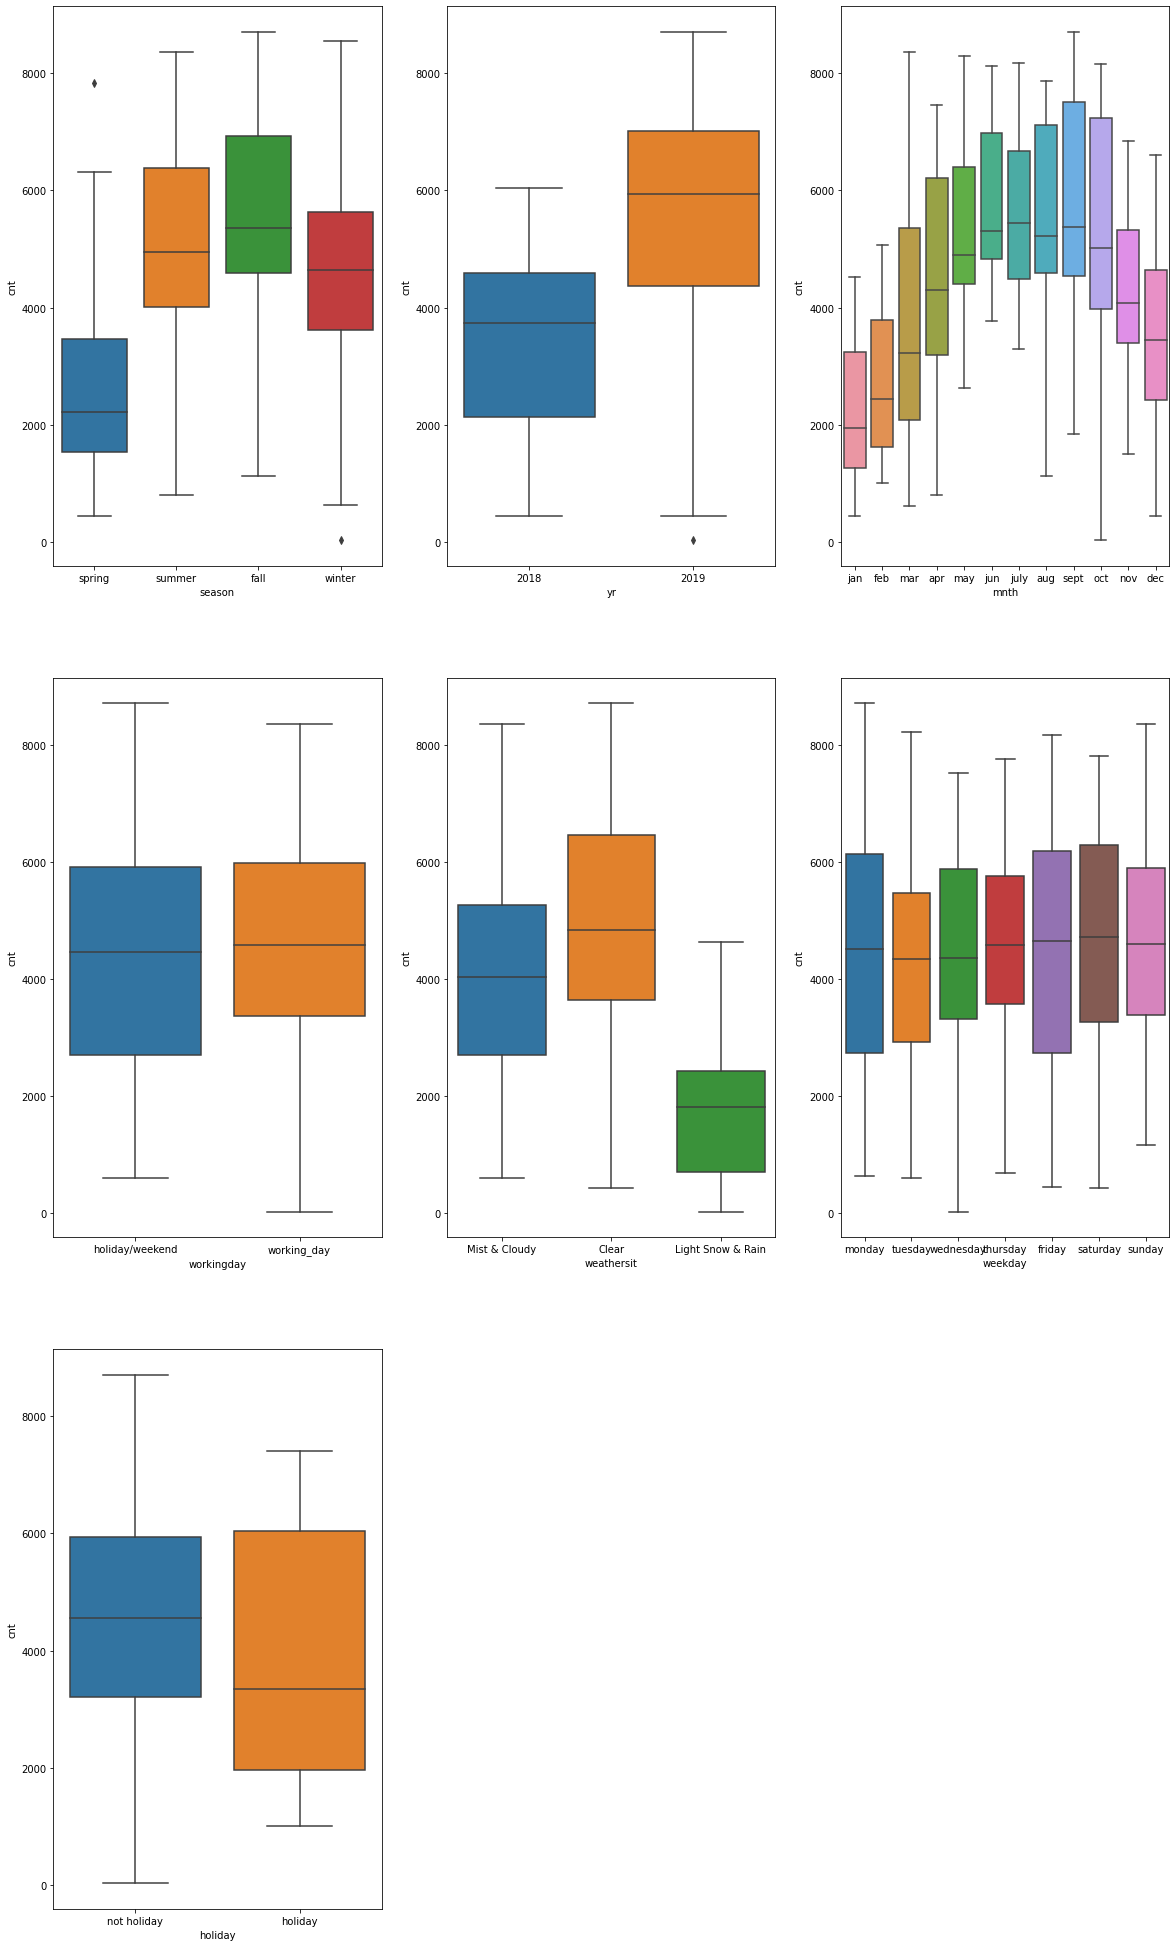

In [17]:
plt.figure(figsize=(20, 35))
plt.subplot(3,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = df)#yr','mnth','workingday','weathersit','weekday'
plt.subplot(3,3,2)
sns.boxplot(x = 'yr', y = 'cnt', data = df)
plt.subplot(3,3,3)
sns.boxplot(x = 'mnth', y = 'cnt', data = df)
plt.subplot(3,3,4)
sns.boxplot(x = 'workingday', y = 'cnt', data = df)
plt.subplot(3,3,5)
sns.boxplot(x = 'weathersit', y = 'cnt', data = df)
plt.subplot(3,3,6)
sns.boxplot(x = 'weekday', y = 'cnt', data = df)
plt.subplot(3,3,7)
sns.boxplot(x = 'holiday', y = 'cnt', data = df)
plt.show()


` cnt = 0.233*const +
        0.102*season_summer + 
        0.149*season_winter + 
        0.053*mnth_aug + 
        0.119*mnth_sept - 
        0.045*weekday_tuesday - 
        0.243*weathersit_Light Snow & Rain - 
        0.058*weathersit_Mist & Cloudy + 
        0.229*yr - 
        0.103*holiday + 
        0.539*temp - 
        0.166*hum - 
        0.182*windspeed '`
       

In [18]:
### mapping back these binary columns as we dnt need one hot encoding for these
df['yr'] = df['yr'].map({'2019':1,'2018':0})
df['holiday'] = df['holiday'].map({'holiday':1,'not holiday':0})
df['workingday'] = df['workingday'].map({'working_day':1,'holiday/weekend':0})



In [87]:
df1 = pd.read_csv('day.csv')

<Figure size 360x360 with 0 Axes>

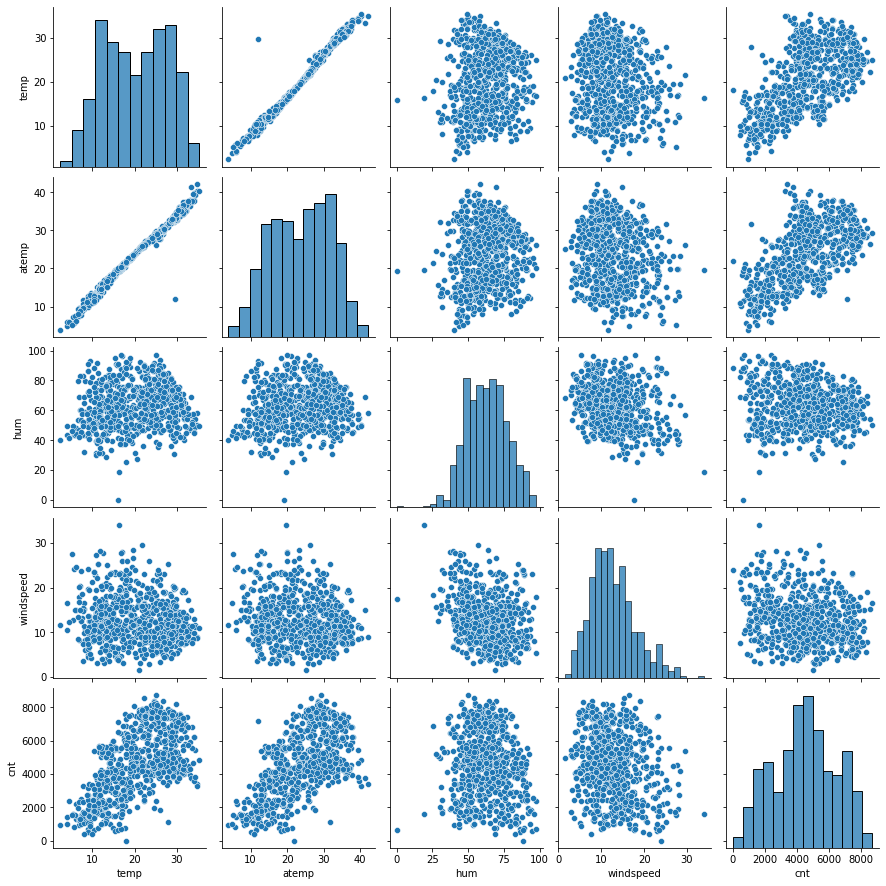

In [91]:
plt.figure(figsize = (5,5))
sns.pairplot(df1, vars=['temp','atemp','hum','windspeed',"cnt"])
plt.show()

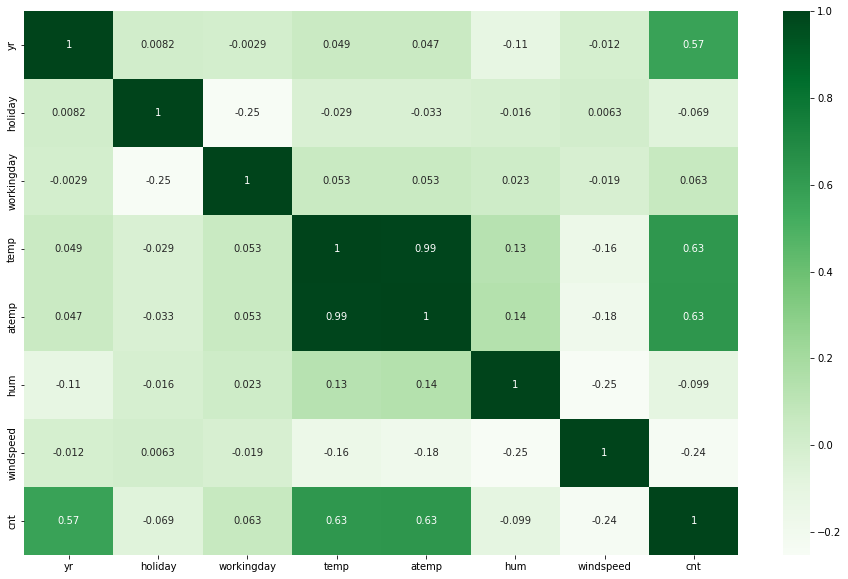

In [20]:

plt.figure(figsize = (16, 10))
sns.heatmap(df.corr(), annot = True, cmap="Greens")

plt.show()

## <b>`Observations`<b>
- bike rentals are most on holidays
- bike rentals are least in spring season and most in fall season
- bike rentals are <b>less</b> in mid week ie on tuesday , wednesday and thursday and also on sunday,
- most bike rentals are on monday and friday
- no bike rental data present for weather- 'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'
- bike rentals shoot up in 2019 as compared to 2018
- bike rentals increase as the year increases and decreases as year ends
- direct corealtion is seen between temp and atemp column so we should drop temp column

In [21]:
df.drop(['atemp'],axis = 1,inplace = True)

## Dummy variable creation

In [22]:
dummy = df[['season','mnth','weekday','weathersit']]

In [23]:
dummy = pd.get_dummies(dummy,drop_first=True)

In [24]:
#### appending labels back to original df
df = pd.concat([dummy,df],axis = 1)

In [25]:
df.head(2)

,season_spring,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_july,mnth_jun,mnth_mar,...,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,0,0,0,0,0,1,0,0,0,...,0,jan,0,monday,0,Mist & Cloudy,14.110847,80.5833,10.749882,985
1,1,0,0,0,0,0,1,0,0,0,...,0,jan,0,tuesday,0,Mist & Cloudy,14.902598,69.6087,16.652113,801


In [26]:
## removing original columns
df.drop(['season','mnth','weekday','weathersit'], axis = 1, inplace = True)

In [27]:
df.head(2)

,season_spring,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_july,mnth_jun,mnth_mar,...,weekday_wednesday,weathersit_Light Snow & Rain,weathersit_Mist & Cloudy,yr,holiday,workingday,temp,hum,windspeed,cnt
0,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,14.110847,80.5833,10.749882,985
1,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,14.902598,69.6087,16.652113,801


## `2. Modeling exercise`
- data split
- data scaling
- model building
- residual analysis
- evaluation

## 2a. data split

In [28]:
train, test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [29]:
train.shape,test.shape

((510, 29), (219, 29))

In [30]:
train.head(2)

,season_spring,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_july,mnth_jun,mnth_mar,...,weekday_wednesday,weathersit_Light Snow & Rain,weathersit_Mist & Cloudy,yr,holiday,workingday,temp,hum,windspeed,cnt
653,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,19.201653,55.8333,12.208807,7534
576,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,29.246653,70.4167,11.083475,7216


In [31]:
test.head(2)

,season_spring,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_july,mnth_jun,mnth_mar,...,weekday_wednesday,weathersit_Light Snow & Rain,weathersit_Mist & Cloudy,yr,holiday,workingday,temp,hum,windspeed,cnt
184,0,0,0,0,0,0,0,1,0,0,...,1,0,1,0,1,0,29.793347,63.7917,5.459106,6043
535,0,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,32.082500,59.2083,7.625404,6211


## 2b. data scaling

In [32]:
scaler = MinMaxScaler()

In [33]:
# scaling numerical variables leaving behind target variable cnt and dummmy varables and binary variables
num_vars = ['hum','windspeed','temp','cnt']

## doing only fit on training set to prevent data leakage on test set
train[num_vars] = scaler.fit_transform(train[num_vars])
test[num_vars] = scaler.transform(test[num_vars])


In [34]:
test.head(2)

,season_spring,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_july,mnth_jun,mnth_mar,...,weekday_wednesday,weathersit_Light Snow & Rain,weathersit_Mist & Cloudy,yr,holiday,workingday,temp,hum,windspeed,cnt
184,0,0,0,0,0,0,0,1,0,0,...,1,0,1,0,1,0,0.831783,0.657364,0.084219,0.692706
535,0,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0.901354,0.610133,0.153728,0.712034


In [35]:
train.head(2)

,season_spring,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_july,mnth_jun,mnth_mar,...,weekday_wednesday,weathersit_Light Snow & Rain,weathersit_Mist & Cloudy,yr,holiday,workingday,temp,hum,windspeed,cnt
653,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0.509887,0.575354,0.300794,0.864243
576,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0.815169,0.725633,0.264686,0.827658


In [36]:
### seperating dependant and independant variables in test train set
y_test = test.pop('cnt')
X_test = test
y_train = train.pop('cnt')
x_train = train

In [37]:
def get_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
  
    # calculating VIF for each feature
    vif_data["VIF"] = [
        vif(X.values, i) for i in range(len(X.columns))
    ]
    return vif_data.sort_values(by = "VIF", ascending = False)

## 2c. Model Building

### `Model 1`
- building model with all the features ie 28 features

#### <b>`Observations`<b>
1. 84% of the variance is explained by independent variables
2. p values for below are very high hence dropping them in next model making it stastically insignificant
- 'mnth_aug' = 0.898 , 
- 'weekday_sunday' = 0.9 , 
- 'mnth_oct' = 0.7 ,
- 'weekday_saturday'  = 0.7 ,
- 'mnth_jun ' = 0.5 ,
- 'mnth_mar' = 0.6 
    
##### dropping the above features in next model


In [38]:
def vif_helper(df):
    val = pd.DataFrame()
    val["independent variables"] = df.columns
    val["VIF"] = [
        vif(df.values, i) for i in range(len(df.columns))
    ]
    return val.sort_values(by = "VIF", ascending = False)

In [39]:
vif_helper(x_train)

,independent variables,VIF
24,workingday,86.809517
14,weekday_monday,19.717912
18,weekday_tuesday,18.350060
0,season_spring,10.785986
2,season_winter,9.501176
1,season_summer,8.289339
25,temp,7.118264
11,mnth_nov,6.795573
12,mnth_oct,6.586439
3,mnth_aug,6.426366


In [40]:
x_train.head(2)

,season_spring,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_july,mnth_jun,mnth_mar,...,weekday_tuesday,weekday_wednesday,weathersit_Light Snow & Rain,weathersit_Mist & Cloudy,yr,holiday,workingday,temp,hum,windspeed
653,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0.509887,0.575354,0.300794
576,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0.815169,0.725633,0.264686


In [41]:
 
x_train1 = sm.add_constant(x_train)
x_train1.head()


,const,season_spring,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_july,mnth_jun,...,weekday_tuesday,weekday_wednesday,weathersit_Light Snow & Rain,weathersit_Mist & Cloudy,yr,holiday,workingday,temp,hum,windspeed
653,1.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0.509887,0.575354,0.300794
576,1.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0.815169,0.725633,0.264686
426,1.0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0.442393,0.640189,0.255342
728,1.0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0.245101,0.498067,0.663106
482,1.0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0.395666,0.504508,0.188475


In [42]:
lm1 = sm.OLS(y_train,x_train1).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     103.8
Date:                Wed, 16 Mar 2022   Prob (F-statistic):          8.74e-182
Time:                        20:14:14   Log-Likelihood:                 527.95
No. Observations:                 510   AIC:                            -999.9
Df Residuals:                     482   BIC:                            -881.3
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [43]:
vif_helper(x_train1)

C:\Users\sonalgupta\Anaconda3\envs\pdf\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\sonalgupta\Anaconda3\envs\pdf\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,independent variables,VIF
25,workingday,inf
24,holiday,inf
19,weekday_tuesday,inf
15,weekday_monday,inf
1,season_spring,10.785986
3,season_winter,9.501176
2,season_summer,8.289339
26,temp,7.118264
12,mnth_nov,6.795573
13,mnth_oct,6.586439


### `Model 2`
- building model by dropping 'workingday' as it has infinite VIF

#### <b>`Observations`<b>
- dropping working day removed infinte VIF scores for all others hence removing multicolinearity

    
##### dropping 'season_spring' features in next model as it has both high p value and high vif

In [44]:
x_train2 = x_train.drop(['workingday'],axis = 1)
x_train2.head()

,season_spring,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_july,mnth_jun,mnth_mar,...,weekday_thursday,weekday_tuesday,weekday_wednesday,weathersit_Light Snow & Rain,weathersit_Mist & Cloudy,yr,holiday,temp,hum,windspeed
653,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0.509887,0.575354,0.300794
576,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0.815169,0.725633,0.264686
426,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0.442393,0.640189,0.255342
728,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0.245101,0.498067,0.663106
482,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0.395666,0.504508,0.188475


In [45]:
x_train2_cnt = sm.add_constant(x_train2)
x_train2_cnt.head()

,const,season_spring,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_july,mnth_jun,...,weekday_thursday,weekday_tuesday,weekday_wednesday,weathersit_Light Snow & Rain,weathersit_Mist & Cloudy,yr,holiday,temp,hum,windspeed
653,1.0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0.509887,0.575354,0.300794
576,1.0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0.815169,0.725633,0.264686
426,1.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0.442393,0.640189,0.255342
728,1.0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0.245101,0.498067,0.663106
482,1.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0.395666,0.504508,0.188475


In [46]:
lm2 = sm.OLS(y_train,x_train2_cnt).fit()
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     103.8
Date:                Wed, 16 Mar 2022   Prob (F-statistic):          8.74e-182
Time:                        20:14:14   Log-Likelihood:                 527.95
No. Observations:                 510   AIC:                            -999.9
Df Residuals:                     482   BIC:                            -881.3
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [47]:
vif_helper(x_train2_cnt)

,independent variables,VIF
0,const,128.327112
1,season_spring,10.785986
3,season_winter,9.501176
2,season_summer,8.289339
25,temp,7.118264
12,mnth_nov,6.795573
13,mnth_oct,6.586439
4,mnth_aug,6.426366
7,mnth_jan,5.900971
5,mnth_dec,5.680304


### `Model 3`
- building model by  dropping 'season_spring' features in next model as it has both high p value and high vif

#### <b>`Observations`<b>
- imporvemnt in p value sof other variavles and well as VIF values
    
#### dropping 'mnth_oct' in next model as it has very high p value of 0.8


In [48]:
x_train3 = x_train2.drop(['season_spring'],axis  =1)
x_train3.head()

,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_july,mnth_jun,mnth_mar,mnth_may,...,weekday_thursday,weekday_tuesday,weekday_wednesday,weathersit_Light Snow & Rain,weathersit_Mist & Cloudy,yr,holiday,temp,hum,windspeed
653,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0.509887,0.575354,0.300794
576,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,1,0,0.815169,0.725633,0.264686
426,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,1,0,0.442393,0.640189,0.255342
728,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0.245101,0.498067,0.663106
482,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0.395666,0.504508,0.188475


In [49]:
x_train3_cnt = sm.add_constant(x_train3)
x_train3_cnt.head()
lm3 = sm.OLS(y_train,x_train3_cnt).fit()
lm3.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     107.4
Date:                Wed, 16 Mar 2022   Prob (F-statistic):          2.99e-182
Time:                        20:14:14   Log-Likelihood:                 526.59
No. Observations:                 510   AIC:                            -999.2
Df Residuals:                     483   BIC:                            -884.9
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.3069      0.040      7.602      0.000       0.228       0.386
season_summer                    0.0663      0.020      3.345      0.001       0.027       0.105
season_winter                    0.1328      0.022      5.941      0.000       0.089       0.177
mnth_aug                         0.0389      0.030      1.292      0.197      -0.020       0.098
mnth_dec                        -0.0501      0.034     -1.496      0.135      -0.116       0.016
mnth_feb                        -0.0510      0.031     -1.657      0.098      -0.112       0.009
mnth_jan                        -0.0810      0.032     -2.563      0.011      -0.143      -0.019
mnth_july                       -0.0165      0.032     -0.518      0.605      -0.079       0.046
mnth_jun                         0.0044      0.025      0.177      0.859      -0.044       0.053
mnth_mar                        -0.0115      0.023     -0.495      0.621      -0.057       0.034
mnth_may                         0.0223      0.021      1.064      0.288      -0.019       0.064
mnth_nov                        -0.0405      0.036     -1.112      0.267      -0.112       0.031
mnth_oct                         0.0076      0.036      0.213      0.831      -0.063       0.078
mnth_sept                        0.1005      0.030      3.390      0.001       0.042       0.159
weekday_monday                   0.0045      0.014      0.318      0.750      -0.023       0.032
weekday_saturday                -0.0030      0.015     -0.206      0.837      -0.032       0.026
weekday_sunday                   0.0058      0.015      0.392      0.695      -0.023       0.035
weekday_thursday                -0.0130      0.015     -0.883      0.377      -0.042       0.016
weekday_tuesday                 -0.0496      0.014     -3.433      0.001      -0.078      -0.021
weekday_wednesday               -0.0146      0.015     -0.999      0.318      -0.043       0.014
weathersit_Light Snow & Rain    -0.2546      0.026     -9.677      0.000      -0.306      -0.203
weathersit_Mist & Cloudy        -0.0605      0.010     -5.793      0.000      -0.081      -0.040
yr                               0.2318      0.008     28.742      0.000       0.216       0.248
holiday                         -0.0879      0.027     -3.303      0.001      -0.140      -0.036
temp                             0.4598      0.046      9.993      0.000       0.369       0.550
hum                             -0.1537      0.039     -3.992      0.000      -0.229      -0.078
windspeed                       -0.1897      0.026     -7.396      0.000      -0.240      -0.139
==============================================================================
Omnibus:                       81.640   Durbin-Watson:                   2.047
Prob(Omnibus): 

In [50]:
vif_helper(x_train3_cnt)

,independent variables,VIF
0,const,105.989184
24,temp,7.009499
11,mnth_nov,6.791668
12,mnth_oct,6.586415
2,season_winter,6.075476
4,mnth_dec,5.639981
6,mnth_jan,5.226233
3,mnth_aug,5.113072
1,season_summer,4.730630
7,mnth_july,4.645835


### `Model 4`
- building model by  dropping ``'mnth_oct'`` features in next model as it has both high p value of 0.8 and vif>5

#### <b>`Observations`<b>
- improvement in p values of other variavles and well as VIF values
    
#### dropping 'mnth_jun' in next model as it has very high p value of 0.8

In [51]:
x_train4 = x_train3.drop(['mnth_oct'],axis = 1)
x_train4_cnt = sm.add_constant(x_train4)
lm4 = sm.OLS(y_train,x_train4_cnt).fit()
lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     111.9
Date:                Wed, 16 Mar 2022   Prob (F-statistic):          2.86e-183
Time:                        20:14:15   Log-Likelihood:                 526.57
No. Observations:                 510   AIC:                            -1001.
Df Residuals:                     484   BIC:                            -891.0
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.3100      0.038      8.256      0.000       0.236       0.384
season_summer                    0.0640      0.016      3.889      0.000       0.032       0.096
season_winter                    0.1357      0.018      7.678      0.000       0.101       0.170
mnth_aug                         0.0354      0.025      1.404      0.161      -0.014       0.085
mnth_dec                        -0.0558      0.020     -2.774      0.006      -0.095      -0.016
mnth_feb                        -0.0546      0.026     -2.124      0.034      -0.105      -0.004
mnth_jan                        -0.0846      0.027     -3.189      0.002      -0.137      -0.032
mnth_july                       -0.0199      0.027     -0.728      0.467      -0.074       0.034
mnth_jun                         0.0024      0.023      0.105      0.916      -0.043       0.047
mnth_mar                        -0.0143      0.019     -0.733      0.464      -0.052       0.024
mnth_may                         0.0211      0.020      1.046      0.296      -0.019       0.061
mnth_nov                        -0.0470      0.019     -2.430      0.015      -0.085      -0.009
mnth_sept                        0.0963      0.022      4.385      0.000       0.053       0.139
weekday_monday                   0.0045      0.014      0.321      0.748      -0.023       0.032
weekday_saturday                -0.0030      0.015     -0.203      0.839      -0.032       0.026
weekday_sunday                   0.0058      0.015      0.392      0.695      -0.023       0.035
weekday_thursday                -0.0131      0.015     -0.886      0.376      -0.042       0.016
weekday_tuesday                 -0.0496      0.014     -3.435      0.001      -0.078      -0.021
weekday_wednesday               -0.0146      0.015     -1.003      0.316      -0.043       0.014
weathersit_Light Snow & Rain    -0.2545      0.026     -9.684      0.000      -0.306      -0.203
weathersit_Mist & Cloudy        -0.0606      0.010     -5.809      0.000      -0.081      -0.040
yr                               0.2317      0.008     28.786      0.000       0.216       0.248
holiday                         -0.0876      0.027     -3.299      0.001      -0.140      -0.035
temp                             0.4594      0.046     10.001      0.000       0.369       0.550
hum                             -0.1527      0.038     -3.999      0.000      -0.228      -0.078
windspeed                       -0.1897      0.026     -7.402      0.000      -0.240      -0.139
==============================================================================
Omnibus:                       80.949   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              219.579
Skew:                          -0

In [52]:
vif_helper(x_train4_cnt)

,independent variables,VIF
0,const,91.885390
23,temp,7.002011
2,season_winter,3.806615
6,mnth_jan,3.693921
3,mnth_aug,3.593579
7,mnth_july,3.443583
1,season_summer,3.261454
5,mnth_feb,2.681928
8,mnth_jun,2.354519
12,mnth_sept,2.323611


### `Model 5`
- building model by  dropping ``'mnth_jun'`` features in next model as it has both high p value of 0.9 and vif>5

#### <b>`Observations`<b>
- improvement in p values of other variavles and well as VIF values
- brought down temp VIF from 7 to 5
    
#### dropping 'weekday_saturday' in next model as it has very high p value of 0.8

In [53]:
x_train5 = x_train4.drop(['mnth_jun'],axis = 1)
x_train5_cnt =sm.add_constant(x_train5)
lm5 = sm.OLS(y_train,x_train5_cnt).fit()
lm5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     116.8
Date:                Wed, 16 Mar 2022   Prob (F-statistic):          2.63e-184
Time:                        20:14:15   Log-Likelihood:                 526.56
No. Observations:                 510   AIC:                            -1003.
Df Residuals:                     485   BIC:                            -897.3
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.3100      0.038      8.265      0.000       0.236       0.384
season_summer                    0.0639      0.016      3.893      0.000       0.032       0.096
season_winter                    0.1351      0.017      8.071      0.000       0.102       0.168
mnth_aug                         0.0338      0.020      1.659      0.098      -0.006       0.074
mnth_dec                        -0.0558      0.020     -2.775      0.006      -0.095      -0.016
mnth_feb                        -0.0548      0.026     -2.142      0.033      -0.105      -0.005
mnth_jan                        -0.0847      0.027     -3.195      0.001      -0.137      -0.033
mnth_july                       -0.0216      0.022     -0.987      0.324      -0.065       0.021
mnth_mar                        -0.0148      0.019     -0.787      0.432      -0.052       0.022
mnth_may                         0.0201      0.018      1.146      0.252      -0.014       0.054
mnth_nov                        -0.0469      0.019     -2.430      0.015      -0.085      -0.009
mnth_sept                        0.0952      0.019      4.964      0.000       0.057       0.133
weekday_monday                   0.0046      0.014      0.323      0.747      -0.023       0.032
weekday_saturday                -0.0030      0.015     -0.206      0.837      -0.032       0.026
weekday_sunday                   0.0058      0.015      0.390      0.696      -0.023       0.035
weekday_thursday                -0.0131      0.015     -0.893      0.372      -0.042       0.016
weekday_tuesday                 -0.0496      0.014     -3.438      0.001      -0.078      -0.021
weekday_wednesday               -0.0146      0.015     -1.003      0.317      -0.043       0.014
weathersit_Light Snow & Rain    -0.2545      0.026     -9.694      0.000      -0.306      -0.203
weathersit_Mist & Cloudy        -0.0605      0.010     -5.818      0.000      -0.081      -0.040
yr                               0.2316      0.008     28.949      0.000       0.216       0.247
holiday                         -0.0879      0.026     -3.325      0.001      -0.140      -0.036
temp                             0.4620      0.039     11.880      0.000       0.386       0.538
hum                             -0.1533      0.038     -4.057      0.000      -0.228      -0.079
windspeed                       -0.1901      0.025     -7.491      0.000      -0.240      -0.140
==============================================================================
Omnibus:                       80.754   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              218.262
Skew:                          -0.779   Prob(JB):                     4.03e-48
Kurtosis:                       5.801   Cond. No.  

In [54]:
vif_helper(x_train5_cnt)

,independent variables,VIF
0,const,91.885339
22,temp,5.028155
6,mnth_jan,3.692482
2,season_winter,3.421923
1,season_summer,3.253451
5,mnth_feb,2.663809
3,mnth_aug,2.355194
7,mnth_july,2.214843
4,mnth_dec,2.037514
8,mnth_mar,2.036512


### `Model 6`
- building model by  dropping ``'weekday_saturday'`` features in next model as it has both high p value of 0.83

#### <b>`Observations`<b>
- improvement in p values of other variables
    
#### dropping 'weekday_monday' in next model as it has very high p value of 0.6

In [55]:
x_train6 = x_train5.drop(['weekday_saturday'],axis = 1)
x_train6_cnt = sm.add_constant(x_train6)
lm6 = sm.OLS(y_train,x_train6_cnt).fit()
lm6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     122.1
Date:                Wed, 16 Mar 2022   Prob (F-statistic):          2.40e-185
Time:                        20:14:15   Log-Likelihood:                 526.54
No. Observations:                 510   AIC:                            -1005.
Df Residuals:                     486   BIC:                            -903.5
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.3085      0.037      8.388      0.000       0.236       0.381
season_summer                    0.0639      0.016      3.899      0.000       0.032       0.096
season_winter                    0.1351      0.017      8.081      0.000       0.102       0.168
mnth_aug                         0.0338      0.020      1.659      0.098      -0.006       0.074
mnth_dec                        -0.0560      0.020     -2.790      0.005      -0.095      -0.017
mnth_feb                        -0.0548      0.026     -2.143      0.033      -0.105      -0.005
mnth_jan                        -0.0847      0.026     -3.200      0.001      -0.137      -0.033
mnth_july                       -0.0217      0.022     -0.990      0.323      -0.065       0.021
mnth_mar                        -0.0149      0.019     -0.795      0.427      -0.052       0.022
mnth_may                         0.0201      0.017      1.148      0.252      -0.014       0.054
mnth_nov                        -0.0471      0.019     -2.441      0.015      -0.085      -0.009
mnth_sept                        0.0951      0.019      4.966      0.000       0.057       0.133
weekday_monday                   0.0059      0.012      0.478      0.633      -0.018       0.030
weekday_sunday                   0.0072      0.013      0.540      0.589      -0.019       0.033
weekday_thursday                -0.0118      0.013     -0.897      0.370      -0.038       0.014
weekday_tuesday                 -0.0482      0.013     -3.767      0.000      -0.073      -0.023
weekday_wednesday               -0.0132      0.013     -1.026      0.306      -0.039       0.012
weathersit_Light Snow & Rain    -0.2544      0.026     -9.701      0.000      -0.306      -0.203
weathersit_Mist & Cloudy        -0.0605      0.010     -5.821      0.000      -0.081      -0.040
yr                               0.2317      0.008     28.980      0.000       0.216       0.247
holiday                         -0.0881      0.026     -3.342      0.001      -0.140      -0.036
temp                             0.4620      0.039     11.891      0.000       0.386       0.538
hum                             -0.1530      0.038     -4.057      0.000      -0.227      -0.079
windspeed                       -0.1901      0.025     -7.499      0.000      -0.240      -0.140
==============================================================================
Omnibus:                       81.078   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              219.473
Skew:                          -0.782   Prob(JB):                     2.20e-48
Kurtosis:                       5.808   Cond. No.                         24.3
=====================================================================

In [56]:
vif_helper(x_train6_cnt)

,independent variables,VIF
0,const,88.543254
21,temp,5.028008
6,mnth_jan,3.692250
2,season_winter,3.421590
1,season_summer,3.253121
5,mnth_feb,2.663657
3,mnth_aug,2.354910
7,mnth_july,2.214638
8,mnth_mar,2.034455
4,mnth_dec,2.033474


In [57]:
x_train7 = x_train6.drop(['weekday_monday'],axis = 1)
x_train7_cnt = sm.add_constant(x_train7)
lm7 = sm.OLS(y_train,x_train7_cnt).fit()
lm7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     127.9
Date:                Wed, 16 Mar 2022   Prob (F-statistic):          2.35e-186
Time:                        20:14:15   Log-Likelihood:                 526.42
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     487   BIC:                            -909.4
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.3111      0.036      8.556      0.000       0.240       0.383
season_summer                    0.0640      0.016      3.910      0.000       0.032       0.096
season_winter                    0.1355      0.017      8.114      0.000       0.103       0.168
mnth_aug                         0.0341      0.020      1.678      0.094      -0.006       0.074
mnth_dec                        -0.0560      0.020     -2.796      0.005      -0.095      -0.017
mnth_feb                        -0.0550      0.026     -2.154      0.032      -0.105      -0.005
mnth_jan                        -0.0849      0.026     -3.208      0.001      -0.137      -0.033
mnth_july                       -0.0211      0.022     -0.967      0.334      -0.064       0.022
mnth_mar                        -0.0150      0.019     -0.803      0.422      -0.052       0.022
mnth_may                         0.0198      0.017      1.134      0.257      -0.015       0.054
mnth_nov                        -0.0476      0.019     -2.474      0.014      -0.085      -0.010
mnth_sept                        0.0951      0.019      4.971      0.000       0.058       0.133
weekday_sunday                   0.0051      0.013      0.405      0.685      -0.020       0.030
weekday_thursday                -0.0138      0.012     -1.117      0.265      -0.038       0.010
weekday_tuesday                 -0.0503      0.012     -4.182      0.000      -0.074      -0.027
weekday_wednesday               -0.0152      0.012     -1.256      0.210      -0.039       0.009
weathersit_Light Snow & Rain    -0.2547      0.026     -9.726      0.000      -0.306      -0.203
weathersit_Mist & Cloudy        -0.0603      0.010     -5.814      0.000      -0.081      -0.040
yr                               0.2316      0.008     28.999      0.000       0.216       0.247
holiday                         -0.0884      0.026     -3.355      0.001      -0.140      -0.037
temp                             0.4611      0.039     11.891      0.000       0.385       0.537
hum                             -0.1535      0.038     -4.072      0.000      -0.228      -0.079
windspeed                       -0.1896      0.025     -7.491      0.000      -0.239      -0.140
==============================================================================
Omnibus:                       79.483   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              217.654
Skew:                          -0.763   Prob(JB):                     5.46e-48
Kurtosis:                       5.813   Cond. No.                         24.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctl

In [58]:
vif_helper(x_train7_cnt)

,independent variables,VIF
0,const,86.658652
20,temp,5.017436
6,mnth_jan,3.691783
2,season_winter,3.415805
1,season_summer,3.252204
5,mnth_feb,2.662758
3,mnth_aug,2.352123
7,mnth_july,2.208144
8,mnth_mar,2.033969
4,mnth_dec,2.033359


### `Model 7`
- building model by  dropping ``'weekday_saturday'`` features in next model as it has both high p value of 0.83

#### <b>`Observations`<b>
- improvement in p values of other variables
    
#### Selecting approiate features using RFE in further models

In [59]:
x_train8 = x_train7.drop(['weekday_sunday'],axis = 1)
x_train8_cnt = sm.add_constant(x_train8)
lm8 = sm.OLS(y_train,x_train8_cnt).fit()
lm8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     134.2
Date:                Wed, 16 Mar 2022   Prob (F-statistic):          2.18e-187
Time:                        20:14:15   Log-Likelihood:                 526.33
No. Observations:                 510   AIC:                            -1009.
Df Residuals:                     488   BIC:                            -915.5
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.3126      0.036      8.655      0.000       0.242       0.384
season_summer                    0.0639      0.016      3.906      0.000       0.032       0.096
season_winter                    0.1355      0.017      8.122      0.000       0.103       0.168
mnth_aug                         0.0342      0.020      1.682      0.093      -0.006       0.074
mnth_dec                        -0.0562      0.020     -2.807      0.005      -0.096      -0.017
mnth_feb                        -0.0550      0.026     -2.155      0.032      -0.105      -0.005
mnth_jan                        -0.0851      0.026     -3.220      0.001      -0.137      -0.033
mnth_july                       -0.0209      0.022     -0.957      0.339      -0.064       0.022
mnth_mar                        -0.0152      0.019     -0.813      0.416      -0.052       0.022
mnth_may                         0.0199      0.017      1.143      0.254      -0.014       0.054
mnth_nov                        -0.0480      0.019     -2.501      0.013      -0.086      -0.010
mnth_sept                        0.0950      0.019      4.968      0.000       0.057       0.133
weekday_thursday                -0.0150      0.012     -1.245      0.214      -0.039       0.009
weekday_tuesday                 -0.0515      0.012     -4.402      0.000      -0.074      -0.028
weekday_wednesday               -0.0164      0.012     -1.392      0.165      -0.040       0.007
weathersit_Light Snow & Rain    -0.2554      0.026     -9.778      0.000      -0.307      -0.204
weathersit_Mist & Cloudy        -0.0600      0.010     -5.805      0.000      -0.080      -0.040
yr                               0.2316      0.008     29.023      0.000       0.216       0.247
holiday                         -0.0882      0.026     -3.350      0.001      -0.140      -0.036
temp                             0.4609      0.039     11.897      0.000       0.385       0.537
hum                             -0.1539      0.038     -4.087      0.000      -0.228      -0.080
windspeed                       -0.1897      0.025     -7.505      0.000      -0.239      -0.140
==============================================================================
Omnibus:                       79.706   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              218.095
Skew:                          -0.765   Prob(JB):                     4.38e-48
Kurtosis:                       5.815   Cond. No.                         24.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
vif_helper(x_train8_cnt)

,independent variables,VIF
0,const,85.686575
19,temp,5.016472
6,mnth_jan,3.690065
2,season_winter,3.415781
1,season_summer,3.250702
5,mnth_feb,2.662748
3,mnth_aug,2.351995
7,mnth_july,2.206722
8,mnth_mar,2.032874
4,mnth_dec,2.032583


### `Model 8`
- building model by first determing best 15 features using RFE
- Droping below values in this model buidling 

    - 'mnth_feb'
    - 'mnth_july'
    - 'mnth_mar'
    - 'mnth_may'
    - 'weekday_thursday'
    - 'weekday_wednesday'

#### <b>`Observations`<b>
- improvement in p values of other variables
- drastic improvement in VIF value of temp from 5 to 2
    
#### Statisticalyy improving model by selecting 13 best features

In [61]:
lin_reg = LinearRegression()
lin_reg.fit(x_train8, y_train)

rfe = RFE(lin_reg, n_features_to_select = 15)
rfe = rfe.fit(x_train8, y_train)

In [62]:
feature_list = list(zip(x_train8.columns,rfe.support_,rfe.ranking_))

In [63]:
## printing list of rejected features by RFE
for r in feature_list:
    if r[1]==False:
        print(r)

('mnth_feb', False, 2)
('mnth_july', False, 4)
('mnth_mar', False, 5)
('mnth_may', False, 3)
('weekday_thursday', False, 7)
('weekday_wednesday', False, 6)


In [64]:
col = x_train8.columns[rfe.support_]
col

Index(['season_summer', 'season_winter', 'mnth_aug', 'mnth_dec', 'mnth_jan',
       'mnth_nov', 'mnth_sept', 'weekday_tuesday',
       'weathersit_Light Snow & Rain', 'weathersit_Mist & Cloudy', 'yr',
       'holiday', 'temp', 'hum', 'windspeed'],
      dtype='object')

In [65]:
x_train9_rfe = x_train8[col]

In [66]:
x_train9_rfe_cnt = sm.add_constant(x_train9_rfe)
lm9 = sm.OLS(y_train,x_train9_rfe_cnt).fit()
lm9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     185.7
Date:                Wed, 16 Mar 2022   Prob (F-statistic):          6.52e-192
Time:                        20:14:15   Log-Likelihood:                 521.19
No. Observations:                 510   AIC:                            -1010.
Df Residuals:                     494   BIC:                            -942.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.2648      0.028      9.383      0.000       0.209       0.320
season_summer                    0.0920      0.011      8.208      0.000       0.070       0.114
season_winter                    0.1531      0.013     11.595      0.000       0.127       0.179
mnth_aug                         0.0507      0.016      3.166      0.002       0.019       0.082
mnth_dec                        -0.0352      0.017     -2.058      0.040      -0.069      -0.002
mnth_jan                        -0.0478      0.018     -2.675      0.008      -0.083      -0.013
mnth_nov                        -0.0348      0.018     -1.915      0.056      -0.071       0.001
mnth_sept                        0.1117      0.016      6.950      0.000       0.080       0.143
weekday_tuesday                 -0.0463      0.011     -4.092      0.000      -0.068      -0.024
weathersit_Light Snow & Rain    -0.2521      0.026     -9.691      0.000      -0.303      -0.201
weathersit_Mist & Cloudy        -0.0592      0.010     -5.717      0.000      -0.080      -0.039
yr                               0.2296      0.008     28.864      0.000       0.214       0.245
holiday                         -0.0984      0.025     -3.890      0.000      -0.148      -0.049
temp                             0.4963      0.026     19.366      0.000       0.446       0.547
hum                             -0.1554      0.037     -4.195      0.000      -0.228      -0.083
windspeed                       -0.1897      0.025     -7.498      0.000      -0.239      -0.140
==============================================================================
Omnibus:                       68.434   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              175.253
Skew:                          -0.680   Prob(JB):                     8.80e-39
Kurtosis:                       5.530   Cond. No.                         18.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
vif_helper(x_train9_rfe_cnt)

,independent variables,VIF
0,const,51.873495
13,temp,2.178168
2,season_winter,2.124995
14,hum,1.898735
6,mnth_nov,1.696180
5,mnth_jan,1.672378
10,weathersit_Mist & Cloudy,1.572911
1,season_summer,1.512948
4,mnth_dec,1.473164
3,mnth_aug,1.449102


### `Model 9` 
- building model by first determing best 13 features using RFE
- Droping below values in this model building 

    - 'mnth_dec'
    - 'mnth_nov'

#### <b>`Observations`<b>
- imprvement in VIF values
- improvement in p values of other variables
    
<!-- #### This is the Final Model -->

In [68]:
lin_reg1 = LinearRegression()
lin_reg1.fit(x_train9_rfe, y_train)

rfe = RFE(lin_reg1, n_features_to_select = 13)
rfe = rfe.fit(x_train9_rfe, y_train)

In [69]:
feature_list = list(zip(x_train9_rfe.columns,rfe.support_,rfe.ranking_))
for r in feature_list:
    if r[1]==False:
        print(r)

('mnth_dec', False, 2)
('mnth_nov', False, 3)


In [70]:
col = x_train9_rfe.columns[rfe.support_]
col
x_train10_rfe = x_train9_rfe[col]

In [71]:
x_train10_rfe_cnt = sm.add_constant(x_train10_rfe)
lm10 = sm.OLS(y_train,x_train10_rfe_cnt).fit()
lm10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     212.2
Date:                Wed, 16 Mar 2022   Prob (F-statistic):          5.25e-193
Time:                        20:14:15   Log-Likelihood:                 518.25
No. Observations:                 510   AIC:                            -1008.
Df Residuals:                     496   BIC:                            -949.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.2513      0.028      9.062      0.000       0.197       0.306
season_summer                    0.0956      0.011      8.594      0.000       0.074       0.117
season_winter                    0.1388      0.011     12.143      0.000       0.116       0.161
mnth_aug                         0.0506      0.016      3.153      0.002       0.019       0.082
mnth_jan                        -0.0370      0.017     -2.145      0.032      -0.071      -0.003
mnth_sept                        0.1169      0.016      7.320      0.000       0.086       0.148
weekday_tuesday                 -0.0453      0.011     -3.997      0.000      -0.068      -0.023
weathersit_Light Snow & Rain    -0.2458      0.026     -9.469      0.000      -0.297      -0.195
weathersit_Mist & Cloudy        -0.0578      0.010     -5.579      0.000      -0.078      -0.037
yr                               0.2296      0.008     28.757      0.000       0.214       0.245
holiday                         -0.1025      0.025     -4.064      0.000      -0.152      -0.053
temp                             0.5152      0.024     21.200      0.000       0.467       0.563
hum                             -0.1598      0.037     -4.320      0.000      -0.233      -0.087
windspeed                       -0.1868      0.025     -7.379      0.000      -0.237      -0.137
==============================================================================
Omnibus:                       60.863   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.194
Skew:                          -0.622   Prob(JB):                     6.61e-33
Kurtosis:                       5.329   Cond. No.                         18.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### `Model 10`  - Final Model
- building model by dropping `'mnth_jan'` as it has greatest VIF among all aorung 0.03

#### <b>`Observations`<b>
- improvement in p values of other variables
    
#### This is the Final Model

In [72]:
x_train11 = x_train10_rfe.drop(['mnth_jan'],axis = 1)
x_train11_cnt = sm.add_constant(x_train11)
lm11 = sm.OLS(y_train,x_train11_cnt).fit()
lm11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     227.9
Date:                Wed, 16 Mar 2022   Prob (F-statistic):          3.33e-193
Time:                        20:14:16   Log-Likelihood:                 515.89
No. Observations:                 510   AIC:                            -1006.
Df Residuals:                     497   BIC:                            -950.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.2333      0.027      8.794      0.000       0.181       0.285
season_summer                    0.1019      0.011      9.479      0.000       0.081       0.123
season_winter                    0.1488      0.010     14.200      0.000       0.128       0.169
mnth_aug                         0.0526      0.016      3.267      0.001       0.021       0.084
mnth_sept                        0.1195      0.016      7.473      0.000       0.088       0.151
weekday_tuesday                 -0.0449      0.011     -3.950      0.000      -0.067      -0.023
weathersit_Light Snow & Rain    -0.2428      0.026     -9.331      0.000      -0.294      -0.192
weathersit_Mist & Cloudy        -0.0577      0.010     -5.549      0.000      -0.078      -0.037
yr                               0.2287      0.008     28.579      0.000       0.213       0.244
holiday                         -0.1032      0.025     -4.076      0.000      -0.153      -0.053
temp                             0.5390      0.022     24.833      0.000       0.496       0.582
hum                             -0.1659      0.037     -4.479      0.000      -0.239      -0.093
windspeed                       -0.1816      0.025     -7.179      0.000      -0.231      -0.132
==============================================================================
Omnibus:                       59.285   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.979
Skew:                          -0.607   Prob(JB):                     5.44e-32
Kurtosis:                       5.302   Cond. No.                         18.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
vif_helper(x_train11_cnt)

,independent variables,VIF
0,const,45.193002
11,hum,1.869481
7,weathersit_Mist & Cloudy,1.566869
10,temp,1.539063
3,mnth_aug,1.443623
1,season_summer,1.373170
2,season_winter,1.318758
6,weathersit_Light Snow & Rain,1.240303
4,mnth_sept,1.213076
12,windspeed,1.181424


## 2d. Residual Analysis

- linear Regression assumes that error terms are normally distributed
- Checking the above assumption by plotting a histogram


#### <b>`Observations`<b>
- we find a normal distribution of error terms

In [74]:
y_train_pred = lm11.predict(x_train11_cnt)

C:\Users\sonalgupta\Anaconda3\envs\pdf\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


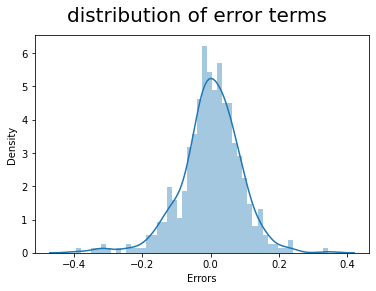

In [75]:
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 50)
fig.suptitle('distribution of error terms', fontsize = 20) 
plt.xlabel('Errors', fontsize = 10)   
plt.show()

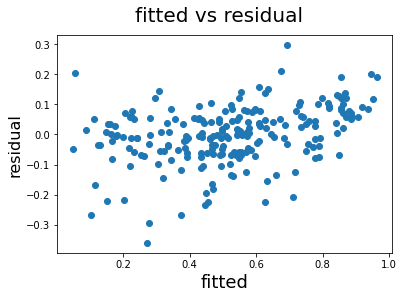

In [94]:
fig = plt.figure()
plt.scatter(y_test,y_test - y_pred)
fig.suptitle('fitted vs residual', fontsize=20)              
plt.xlabel('fitted', fontsize=18)                          
plt.ylabel('residual', fontsize=16)  
plt.show()

In [92]:
vif_helper(x_train11_cnt)

,independent variables,VIF
0,const,45.193002
11,hum,1.869481
7,weathersit_Mist & Cloudy,1.566869
10,temp,1.539063
3,mnth_aug,1.443623
1,season_summer,1.373170
2,season_winter,1.318758
6,weathersit_Light Snow & Rain,1.240303
4,mnth_sept,1.213076
12,windspeed,1.181424


## 2e. Model Evaluation on test data

In [76]:
X_test_new = X_test[x_train11.columns]
X_test_new.head(2)

,season_summer,season_winter,mnth_aug,mnth_sept,weekday_tuesday,weathersit_Light Snow & Rain,weathersit_Mist & Cloudy,yr,holiday,temp,hum,windspeed
184,0,0,0,0,0,0,1,0,1,0.831783,0.657364,0.084219
535,1,0,0,0,0,0,0,1,0,0.901354,0.610133,0.153728


In [77]:
X_test_sm = sm.add_constant(X_test_new)

In [78]:
y_pred = lm11.predict(X_test_sm)

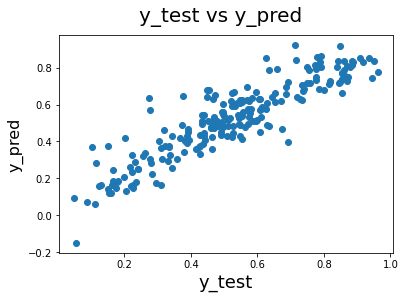

In [79]:

fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              
plt.xlabel('y_test', fontsize=18)                          
plt.ylabel('y_pred', fontsize=16)  
plt.show()

### r_2 score

In [80]:
print("r2_score on test set is ",r2_score(y_test,y_pred))

r2_score on test set is  0.8070679037347958


In [81]:
print("r2_score on train set is ",r2_score(y_train,y_train_pred))

r2_score on train set is  0.8461975480752619


### rsme score

In [82]:
print("root mean square on test set is ",math.sqrt(mean_squared_error(y_test,y_pred)))

root mean square on test set is  0.0957259934931163


<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------<b>

In [83]:
equation = ''
for a,b in zip(list(lm11.params.index),list(lm11.params.values)):
    k = ''
    if str(round(b,3))[0] == '-':
        k = '-'
        al = str(round(b,3))[1:]
    else:
        k = '+'
        al = str(round(b,3))
    equation+= k+' '+al+'*'+a + ' '
equation

'+ 0.233*const + 0.102*season_summer + 0.149*season_winter + 0.053*mnth_aug + 0.119*mnth_sept - 0.045*weekday_tuesday - 0.243*weathersit_Light Snow & Rain - 0.058*weathersit_Mist & Cloudy + 0.229*yr - 0.103*holiday + 0.539*temp - 0.166*hum - 0.182*windspeed '

# `Conclusion`

## Final regression line - 

` cnt = 0.233*const +
        0.102*season_summer + 
        0.149*season_winter + 
        0.053*mnth_aug + 
        0.119*mnth_sept - 
        0.045*weekday_tuesday - 
        0.243*weathersit_Light Snow & Rain - 
        0.058*weathersit_Mist & Cloudy + 
        0.229*yr - 
        0.103*holiday + 
        0.539*temp - 
        0.166*hum - 
        0.182*windspeed '`

### Using the above regression equation we get a test set rsme score of 0.09 which is good, also r2_score for test set is .80 and for train is .84 

### In line with the company business the follwing point should be kept in mind

- weather conditions play an important role in bike sharing demand
- during summer and winters people to rent bikes hence more focus should be there on expanding businees in these weather conditions
- during light snow or cloudy weather settings company should look into expanding its business
- he company should keep expanding its business as when passing year the demands are increaing




In [84]:
os.getcwd()

'D:\\personal\\study\\iiitb\\machine learning1\\assignment\\bike_sharing_case_study'